## Imports:

In [14]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.19.0
Num GPUs Available: 0


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

## Dataset Loading:

In [2]:
# Paths
train_dir = '../dataset/plant_dataset/train'
valid_dir = '../dataset/plant_dataset/valid'

# Image Data Generator with real-time augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_gen = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
valid_gen = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


## Visualize the data:

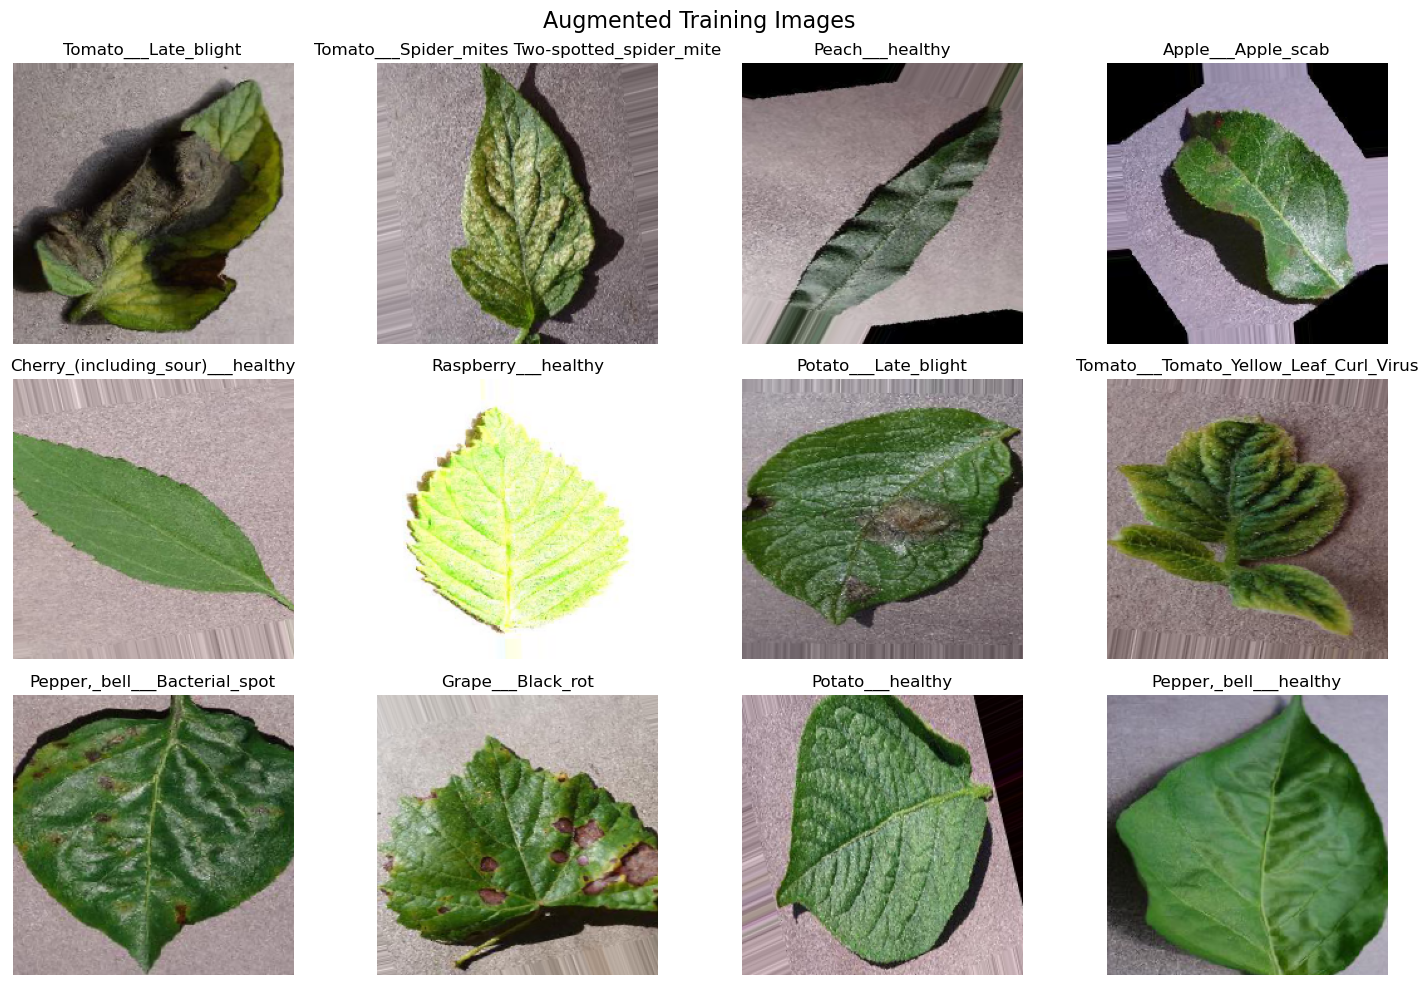

In [3]:
# Get class labels mapping
class_labels = list(train_gen.class_indices.keys())

# Fetch one batch of images and labels
images, labels = next(train_gen)

# Plot the first 12 images in the batch
plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])
    plt.title(class_labels[label_index])
    plt.axis('off')

plt.suptitle("Augmented Training Images", fontsize=16)
plt.tight_layout()
plt.show()

## Model Building (Transfer Learning with MobileNetV2):

In [4]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Add custom top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
preds = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Callbacks (Checkpoints, EarlyStop, LR Reduce)

In [5]:
os.makedirs("outputs/saved_model", exist_ok=True)

checkpoint_path = "outputs/saved_model/best_model.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

callbacks = [checkpoint, early_stop, lr_reduce]

## Model Training:

In [6]:
# Training
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=valid_gen,
    callbacks=callbacks
)

C:\Users\etern\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.7376 - loss: 0.8966
Epoch 1: val_loss improved from inf to 0.32633, saving model to outputs/saved_model/best_model.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2072s 941ms/step - accuracy: 0.7377 - loss: 0.8965 - val_accuracy: 0.8948 - val_loss: 0.3263 - learning_rate: 0.0010
Epoch 2/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.8915 - loss: 0.3264
Epoch 2: val_loss improved from 0.32633 to 0.23432, saving model to outputs/saved_model/best_model.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1744s 794ms/step - accuracy: 0.8915 - loss: 0.3263 - val_accuracy: 0.9209 - val_loss: 0.2343 - learning_rate: 0.0010
Epoch 3/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.9057 - loss: 0.2809
Epoch 3: val_loss improved from 0.23432 to 0.20860, saving model to outputs/saved_model/best_model.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2159s 983ms/step - accuracy: 0.9057 - loss: 0.2809 - val_accuracy: 0.9293 - val_loss: 0.2086

## Evaluation Metrics:

In [16]:
# Predict on the validation set
y_pred = model.predict(valid_gen)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = valid_gen.classes

# Get class label mapping
class_indices = valid_gen.class_indices
class_labels = list(class_indices.keys())

# Print prediction percentages for each sample
confidence_percentages = np.max(y_pred, axis=1) * 100

# Create a DataFrame for easy viewing
import pandas as pd

pred_df = pd.DataFrame({
    "True Label": [class_labels[i] for i in y_true],
    "Predicted Label": [class_labels[i] for i in y_pred_labels],
    "Confidence (%)": confidence_percentages.round(2)
})

# Show top 10 predictions
print(pred_df.head(10))

550/550 ━━━━━━━━━━━━━━━━━━━━ 253s 459ms/step
           True Label                                Predicted Label  \
0  Apple___Apple_scab                       Apple___Cedar_apple_rust   
1  Apple___Apple_scab                       Apple___Cedar_apple_rust   
2  Apple___Apple_scab                         Peach___Bacterial_spot   
3  Apple___Apple_scab                         Pepper,_bell___healthy   
4  Apple___Apple_scab                        Squash___Powdery_mildew   
5  Apple___Apple_scab                             Apple___Apple_scab   
6  Apple___Apple_scab         Tomato___Tomato_Yellow_Leaf_Curl_Virus   
7  Apple___Apple_scab                           Tomato___Target_Spot   
8  Apple___Apple_scab  Tomato___Spider_mites Two-spotted_spider_mite   
9  Apple___Apple_scab                   Grape___Esca_(Black_Measles)   

   Confidence (%)  
0       99.989998  
1      100.000000  
2       99.419998  
3       99.879997  
4      100.000000  
5       98.879997  
6      100.000000  
7 

## Classification Report

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.02      0.02      0.02       504
                                 Apple___Black_rot       0.03      0.03      0.03       497
                          Apple___Cedar_apple_rust       0.03      0.03      0.03       440
                                   Apple___healthy       0.03      0.03      0.03       502
                               Blueberry___healthy       0.03      0.03      0.03       454
          Cherry_(including_sour)___Powdery_mildew       0.03      0.03      0.03       421
                 Cherry_(including_sour)___healthy       0.03      0.04      0.03       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.01      0.01      0.01       410
                       Corn_(maize)___Common_rust_       0.01      0.01      0.01       477
               Corn_(maize)___Northern_Leaf_Blight       0.03      0.03      0.

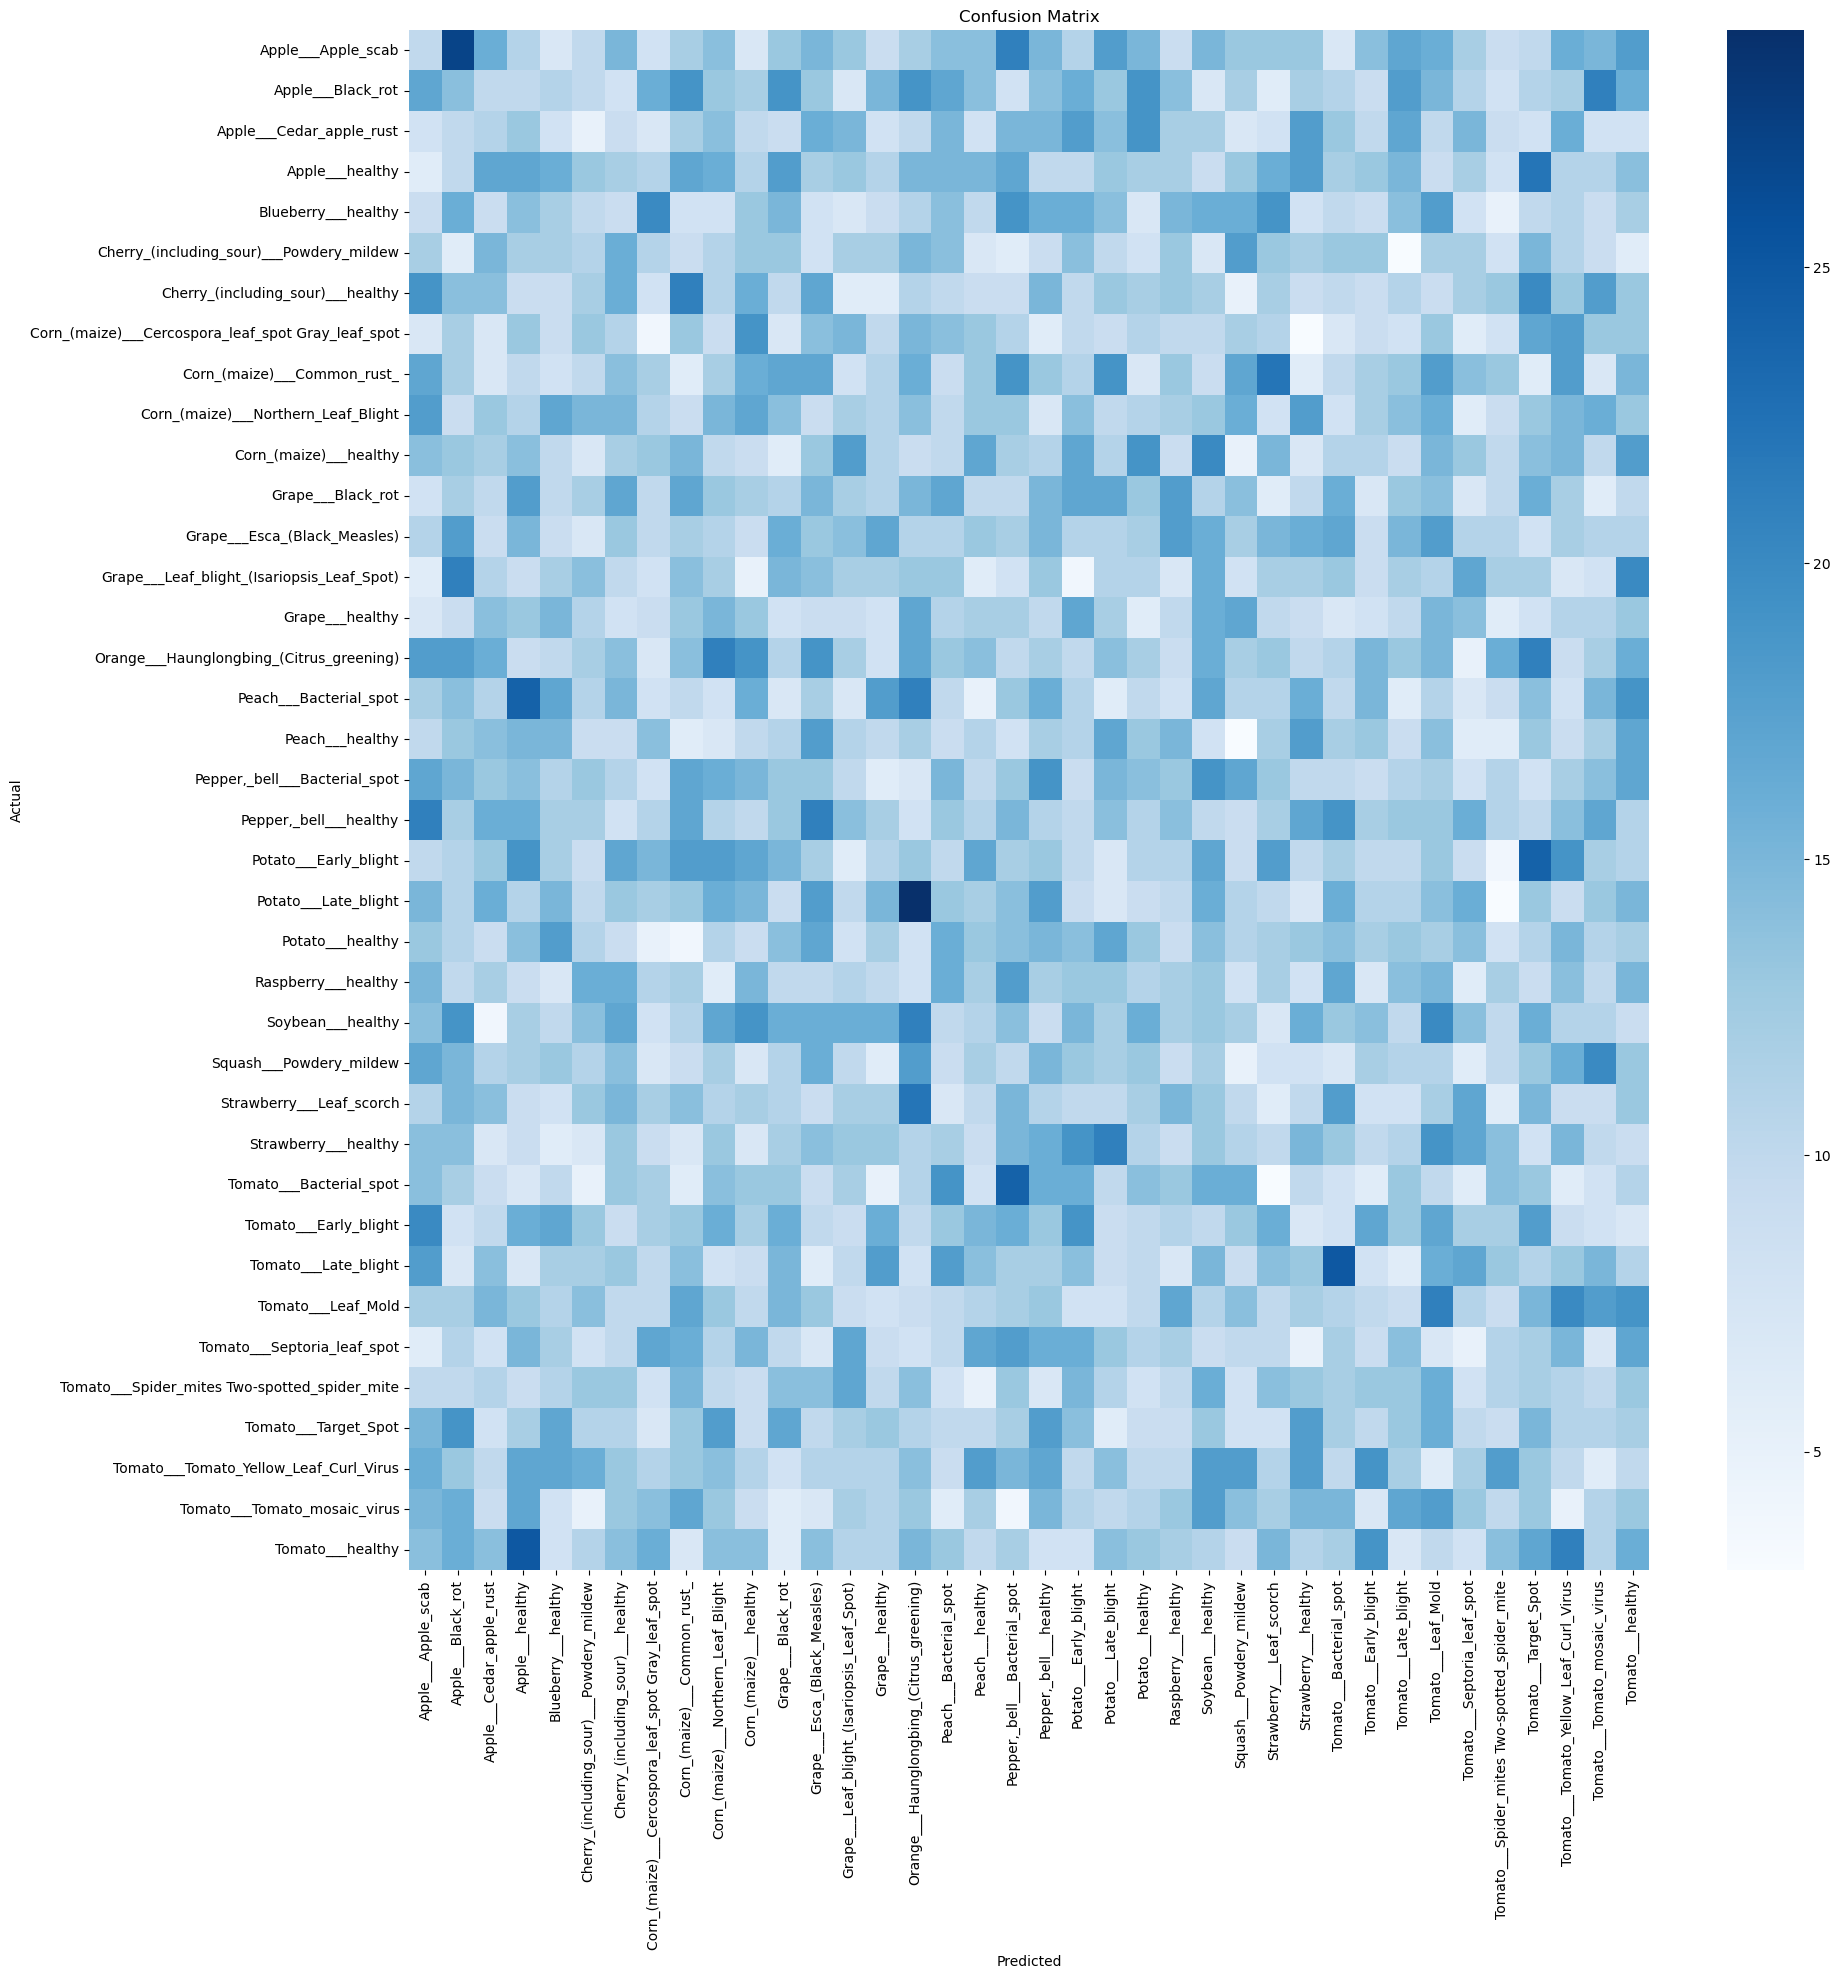

In [17]:
print(classification_report(y_true, y_pred_labels, target_names=list(valid_gen.class_indices.keys())))

# F1-score
f1 = f1_score(y_true, y_pred_labels, average='macro')
print("Macro F1-score:", f1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=valid_gen.class_indices.keys(),
            yticklabels=valid_gen.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Training History Visualization:

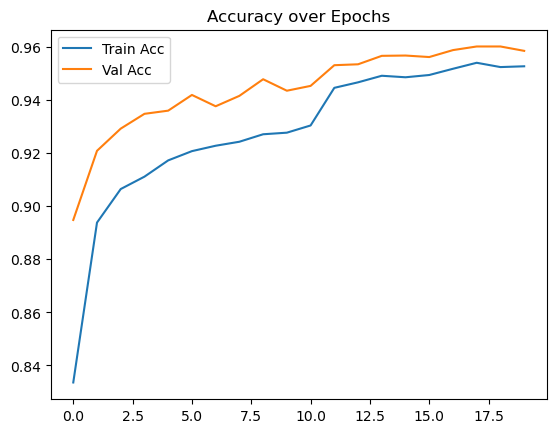

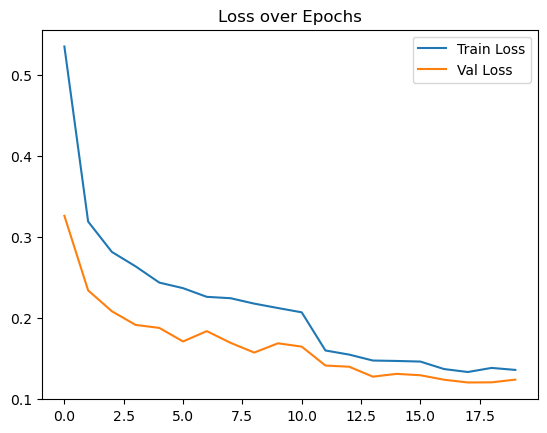

In [18]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

## Save Model:

In [19]:
final_model_path = "outputs/saved_model/plant_disease_model_final.keras"
model.save(final_model_path)
print(f"Final model saved at: {final_model_path}")

Final model saved at: outputs/saved_model/plant_disease_model_final.keras


## Model summary:

In [20]:
# number of trainable parameters in each layer
model.summary()

# Weights of the last Dense layer
final_dense_layer = model.layers[-1]
weights, biases = final_dense_layer.get_weights()

print("Weights shape:", weights.shape)
print("Biases shape:", biases.shape)

# Small sample
print("Sample weights:\n", weights[:5][:5])
print("Sample biases:\n", biases[:5])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,764,596 (10.55 MB)

 Trainable params: 168,870 (659.65 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 337,742 (1.29 MB)

Weights shape: (128, 38)
Biases shape: (38,)
Sample weights:
 [[-0.08355748  0.01722841 -0.1628795   0.07648744 -0.10317571  0.16567206
  -0.08723144  0.09016517  0.03786568  0.1705455   0.23163089 -0.14380558
  -0.08606312 -0.16761799 -0.31130174 -0.09044746 -0.0946059   0.13919747
  -0.04399047 -0.09690833 -0.09138612 -0.00122853  0.03752661 -0.10866728
  -0.12638862 -0.03164537  0.13698629 -0.09093361 -0.00703043  0.1716978
   0.12103127  0.07175393  0.00846823 -0.08003259 -0.12372969 -0.05932098
  -0.14907125 -0.04786564]
 [ 0.05647722 -0.09459829  0.1555575  -0.04055982  0.10037514 -0.06641421
  -0.06228787  0.16524549 -0.11578361 -0.05996163 -0.12433033  0.00081018
  -0.21427184 -0.1354866  -0.18646799  0.01541685 -0.12953979  0.01132122
  -0.06922318 -0.08052673 -0.01183173  0.01955379 -0.17830993  0.06647608
   0.04888803  0.11717586  0.07902908  0.10700607  0.07088146 -0.10898113
   0.08300992 -0.14206743  0.0083306   0.08130944  0.15967233  0.19768004
   0.15728727  0.0805836